## Graph

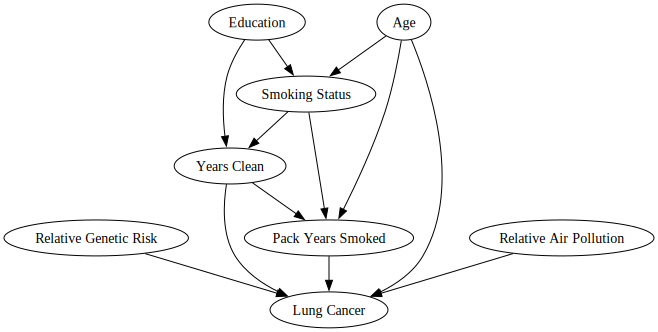

In [22]:
from graphviz import Digraph

dot = Digraph()
dot.node('L', 'Lung Cancer')#Bernoulli
dot.node('G', 'Relative Genetic Risk') # wether genes support addiction, nicotine, cancer etc., Normal distribution
dot.node('S', 'Smoking Status') # packs per year, Poisson distribution
dot.node('Y', 'Pack Years Smoked') # packs per year, Poisson distribution


dot.node('A', 'Age') #what distribution
dot.node("E", "Education") #What degree of education, Poission?
dot.node("C", "Years Clean") # years since quitting, Poisson

dot.node("R", "Relative Air Pollution") # Pollution+second hand smoking

dot.edges(['SY',"AY", "YL","AL", "ES", "AS", "RL", "GL", "CL", "SC", "EC", "CY"])
           
dot

# age	relative_genetic_risk	education	smoking_status	pack_years_smoked	years_clean	relative_air_pollution	lung_cancer

## Synthetic data

### Age

A cohort of people aged 40+.

                  0
count  10000.000000
mean      53.245200
std        9.411022
min       40.000000
25%       46.000000
50%       52.000000
75%       59.000000
max       88.000000


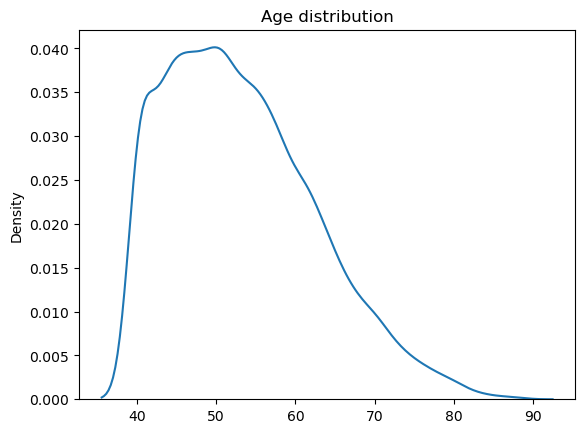

In [23]:
from matplotlib import pyplot as plt
import pandas as pd, numpy as np, seaborn as sns

n_samples = 10000
min_age = 40
max_age = 100

age = np.random.beta(a = 2, b = 5, size = n_samples)*60+36
age = np.clip(np.round(age, 0), min_age, max_age).astype("int")



print(pd.DataFrame(age).describe())

sns.kdeplot(age)
plt.title("Age distribution")
plt.show()

df = pd.DataFrame({"age": age})

### Genetic risk

Roughly 5 people in 100k develops lung cancer among 40-year-olds with no smoking history.

https://www.researchgate.net/figure/Age-specific-incidence-rates-of-lung-cancer-in-the-lifelong-never-smokers-CPS-II-in-the_fig1_51868313

We're living in the future - based on genetic profiling, we can determine how likely that person is to develop lung cancer compared to the average person. Note - this fictional research has been done on non-smokers, so these risks (probably) don't have an effect on smokers.

                  0
count  10000.000000
mean       1.767950
std        2.202465
min        0.025055
25%        0.552431
50%        1.084974
75%        2.125552
max       35.707213


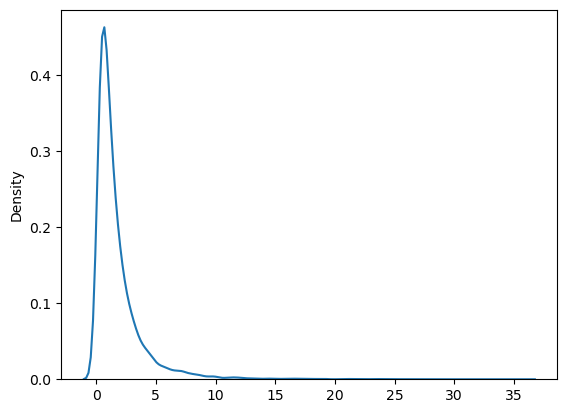

In [24]:
relative_genetic_risk = np.random.lognormal(mean = 0.1, sigma = 1,size = n_samples)

print(pd.DataFrame(relative_genetic_risk).describe())

sns.kdeplot(relative_genetic_risk)
plt.show()

df["relative_genetic_risk"] = np.round(relative_genetic_risk, 2)

### Education

Based on https://rahvaloendus.ee/en/results/education 

                 0
count  10000.00000
mean       1.49960
std        1.06476
min        0.00000
25%        1.00000
50%        1.00000
75%        2.00000
max        4.00000


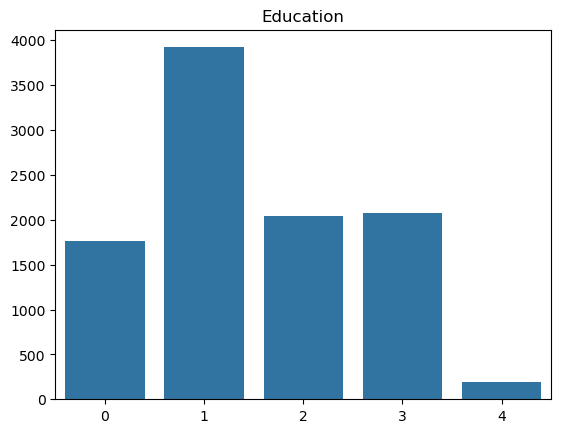

In [25]:
education_probs = np.array([.18, .40, .20, .20, .02])
education_levels = np.array(["Basic education or lower", "High school graduate", "Bachelor's degree or vocational degree", "Master's degree", "PhD"])

highest_level_of_education = np.random.choice(5, p = education_probs, size = n_samples)
levels, counts = np.unique(highest_level_of_education, return_counts=True)

print(pd.DataFrame(highest_level_of_education).describe())

sns.barplot(x=levels, y=counts)
plt.title("Education")
plt.show()

df["education"] = education_levels[highest_level_of_education]

### Probability of having smoked

Roughly 50% of people with no high school diploma are frequent smokers.

https://pmc.ncbi.nlm.nih.gov/articles/PMC7025916/table/tbl02/ 

https://truthinitiative.org/sites/default/files/styles/infographic_original/public/media/images/standard/2019/03/EducationLevelVsTobaccoUse_R3-04%5B1%5D.jpg?itok=jzIjoVI- (not a good source, I'll admit)

Since we're gonna take into account time since smoking cessation, I'll add a bit to the initial risks. Let's say each level of education reduces the risk by some amount (I'll go with 12%).


In [26]:
base_smoking_prob = 0.55
education_smoking_multiplier = 0.12
age_smoking_multiplier = 0.005

has_smoked = np.random.binomial(n = 1, p = np.clip(base_smoking_prob - (age-65)*age_smoking_multiplier- education_smoking_multiplier * highest_level_of_education, 0, 1), size = n_samples)

test = pd.DataFrame({"has_smoked": has_smoked, "education": highest_level_of_education})
test[test["has_smoked"]==1].describe()

,has_smoked,education
count,4304.0,4304.000000
mean,1.0,1.179600
std,0.0,0.953993
min,1.0,0.000000
25%,1.0,1.000000
50%,1.0,1.000000
75%,1.0,2.000000
max,1.0,4.000000


### Intensity of smoking

There are smokers who smoke a few cigarettes every now and then and there are heavy smokers who smoke a pack or more a day. 

Roughly 25% of smokers seem to be heavy smokers ([source](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=File:Share_of_daily_smokers_of_cigarettes_among_persons_aged_15_and_over,_by_level_of_consumption,_2019_(%25)_HLTH2022.png))


Here's a distribution from some other study 

https://www.researchgate.net/figure/Number-of-cigarettes-smoked-per-day-category-distributions-among-adult-and-youth-daily_fig2_262582280

Let's let education have an effect on the amount of heavy smokers in the group.

In [27]:
heavy_smoker_prob = 0.25
education_heavy_smoker_multiplier = 0.04
heavy_smoker = np.where(has_smoked == 1, np.random.binomial(n = 1, p = heavy_smoker_prob - education_heavy_smoker_multiplier*highest_level_of_education, size = n_samples), 0)

pd.DataFrame({"has_smoked": has_smoked, "education": highest_level_of_education, "heavy_smoker": heavy_smoker}).groupby("education").agg({"has_smoked": "mean", "heavy_smoker": "mean"})

,has_smoked,heavy_smoker
education,,
0,0.603166,0.143019
1,0.497960,0.104793
2,0.364614,0.065005
3,0.251208,0.036232
4,0.093264,0.015544


Let's pull the number of daily cigarettes from a Poisson distribution (lambda 20 for heavy smokers, lambda 8 for others). This means that some of the "not heavy" smokers will be smoking more than some of the heavy smokers, but since the heavy_smoker column won't make it to the final dataframe, I guess we can live with that. 

                 0
count  4303.000000
mean     10.401348
std       5.738285
min       1.000000
25%       7.000000
50%       9.000000
75%      12.000000
max      34.000000


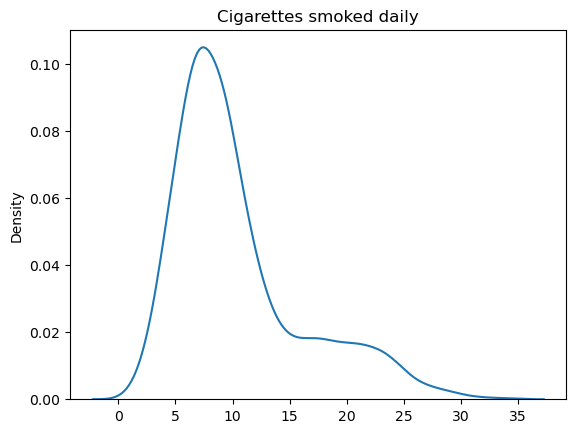

In [28]:
cigarettes_daily = np.where(has_smoked == 1, np.where(heavy_smoker == 1, np.random.poisson(lam=20, size = n_samples), np.random.poisson(lam=8, size = n_samples)), 0)

print(pd.DataFrame(cigarettes_daily[cigarettes_daily > 0]).describe())

sns.kdeplot(cigarettes_daily[cigarettes_daily > 0])
plt.title("Cigarettes smoked daily")
plt.show()

### People who have quit smoking

Smoking is difficult to quit, let's say 10% of smokers have been able to do it (ChatGPT guessed 7-9%), heavy smokers probably less than that. Again, education probably helps.

Also, people tend to relapse, so let's say most people who have quit have quit in the last 5 years.

In [29]:
base_quitting_prob = 0.05
education_quitting_multiplier = 0.05
has_quit = np.where(has_smoked == 1, 
                    np.where(heavy_smoker == 1, 
                             np.random.binomial(n = 1, p = 0.5*base_quitting_prob + education_quitting_multiplier*highest_level_of_education, size = n_samples),
                             np.random.binomial(n = 1, p = base_quitting_prob + education_quitting_multiplier*highest_level_of_education, size = n_samples)), 
                    0)
years_clean = np.round(np.where(has_quit == 1, np.round(np.random.exponential(scale = 5, size = n_samples) + 3, 0), 0), 0)

pd.DataFrame(years_clean[years_clean > 0]).describe()

,0
count,459.000000
mean,8.002179
std,5.200982
min,3.000000
25%,4.000000
50%,6.000000
75%,10.000000
max,37.000000


### Age at which smoking started

Usually pretty young.

https://www.researchgate.net/figure/DISTRIBUTION-OF-RESPONDENTS-ACCORDING-TO-THEIR-AGE-AT-WHICH-THEY-STARTED-SMOKING_tbl1_8900828

Let's not have anyone starting younger than 8. Let's just not.

                 0
count  4304.000000
mean     16.920307
std       3.106210
min       8.000000
25%      15.000000
50%      17.000000
75%      19.000000
max      30.000000


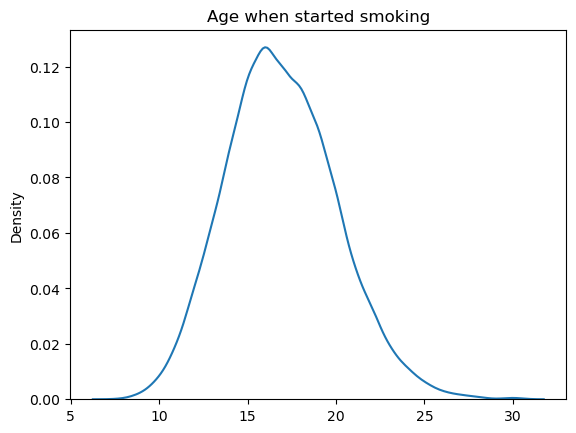

In [30]:
age_started_smoking = np.where(has_smoked == 1, np.random.poisson(lam=10, size = n_samples)+ 7, 0)

print(pd.DataFrame(age_started_smoking[has_smoked==1]).describe())

sns.kdeplot(age_started_smoking[has_smoked == 1])
plt.title("Age when started smoking")
plt.show()

### Pack years smoked

Pack years are calculated by multiplying average daily cigarettes with length of smoking period in years and dividing the result by 20 (20 cigarettes in a pack).

                 0
count  4304.000000
mean     17.978857
std      11.735435
min      -0.000000
25%      10.000000
50%      15.000000
75%      22.000000
max      88.000000


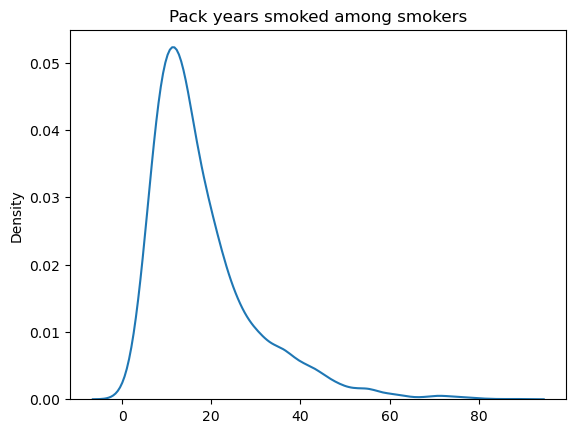

In [31]:
pack_years = np.round(cigarettes_daily / 20 * (age - years_clean - age_started_smoking))
pack_years = np.where(pack_years < 0, 0, pack_years)

print(pd.DataFrame(pack_years[has_smoked == 1]).describe())

sns.kdeplot(pack_years[has_smoked == 1])
plt.title("Pack years smoked among smokers")
plt.show()

In [32]:
df["smoking_status"] = np.where(pack_years == 0, 
                                "Never smoked", 
                                np.where(years_clean > 0, 
                                         "Former smoker", 
                                         "Current smoker"))
df["pack_years_smoked"] = pack_years.astype("int")
df["years_clean"] = np.round(np.where(pack_years == 0, 
                                      age, 
                                      years_clean), 
                                      0).astype("int")

### Air pollution

Air pollution at their place of residence is probably not related to genetic risk and possibly not with education. Just go for log-normal again. Let's say some places are roughly 30 times worse than average and some places 30 times better

                  0
count  10000.000000
mean       1.663699
std        1.890019
min        0.034421
25%        0.606665
50%        1.120260
75%        2.043713
max       56.818740


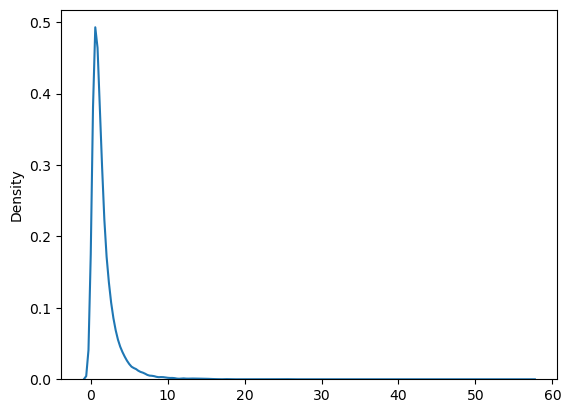

In [33]:
relative_air_pollution = np.random.lognormal(mean = 0.1, sigma = 0.9, size = n_samples)

print(pd.DataFrame(relative_air_pollution).describe())

sns.kdeplot(relative_air_pollution)
plt.show()

df["relative_air_pollution"] = np.round(relative_air_pollution, 2)

### Lung cancer

Combine the previous factors together. Effect of age and smoking should not be simply linear.

In [34]:
lung_cancer_prob = np.clip(1/10000 * relative_genetic_risk * np.float_power(age - 39, 1.3) + 
                    1/1000 * np.float_power(pack_years, 1.1) +
                    1/10000 * relative_air_pollution - 
                    np.where(has_smoked == 1, np.clip(1/15000 * years_clean, 0, 1/1000*np.float_power(pack_years, 1.1)), 0) #stopping smoking cant reduce more than the effect of smoking was
                    , 0, 1)

lung_cancer = np.random.binomial(n = 1, p = lung_cancer_prob, size = n_samples)

print(pd.DataFrame(lung_cancer_prob).describe())
print(np.sum(lung_cancer))

df["lung_cancer"] = lung_cancer

                  0
count  10000.000000
mean       0.016790
std        0.020631
min        0.000043
25%        0.002377
50%        0.009562
75%        0.023685
max        0.306924
159


In [35]:
df

,age,relative_genetic_risk,education,smoking_status,pack_years_smoked,years_clean,relative_air_pollution,lung_cancer
0,53,0.32,High school graduate,Current smoker,27,0,0.34,0
1,42,1.05,High school graduate,Current smoker,32,0,2.78,0
2,41,0.58,Master's degree,Never smoked,0,41,1.22,0
3,43,3.53,High school graduate,Current smoker,20,0,1.83,0
4,66,1.35,Bachelor's degree or vocational degree,Never smoked,0,66,0.67,0
...,...,...,...,...,...,...,...,...
9995,58,0.54,High school graduate,Never smoked,0,58,3.29,0
9996,40,0.93,High school graduate,Current smoker,12,0,0.63,0
9997,67,0.40,Master's degree,Never smoked,0,67,2.38,0
9998,48,2.90,High school graduate,Never smoked,0,48,0.32,0


In [36]:
df.describe()

,age,relative_genetic_risk,pack_years_smoked,years_clean,relative_air_pollution,lung_cancer
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.245200,1.767921,7.738100,31.136700,1.663690,0.015900
std,9.411022,2.202460,11.769408,27.364731,1.889997,0.125095
min,40.000000,0.030000,0.000000,0.000000,0.030000,0.000000
25%,46.000000,0.550000,0.000000,0.000000,0.610000,0.000000
50%,52.000000,1.085000,0.000000,43.000000,1.120000,0.000000
75%,59.000000,2.130000,13.000000,55.000000,2.040000,0.000000
max,88.000000,35.710000,88.000000,88.000000,56.820000,1.000000


In [37]:
df.groupby("smoking_status").agg({"lung_cancer": "mean"})

,lung_cancer
smoking_status,
Current smoker,0.030949
Former smoker,0.019912
Never smoked,0.005436


In [38]:
df[df["lung_cancer"] == 1].groupby("smoking_status").agg({"lung_cancer": "count"})

,lung_cancer
smoking_status,
Current smoker,119
Former smoker,9
Never smoked,31


In [40]:
df.to_csv("Tambets_Jesse_data.tsv", sep = "\t", index = False)